## Runnning with gammapy-dev/IRF_model
Fitting asimov datasets with nuisance parameters based on the different livetimes

### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets, FluxPointsDataset
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints, FluxPointsEstimator
from scipy.interpolate import interp2d

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../')
import Dataset_load 

from  Dataset_Setup import Setup, GaussianCovariance_matrix

from matplotlib import rc
rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
rc("text", usetex=True)

## Read dataset

In [2]:
c = Dataset_load.load_config()
awo, aw, ewo, ew = c['_colors']  

In [3]:
livetime = c['livetime']
zero = c['zero'] 
norm = c['norm'] 
tilt = c['tilt'] 
bias = c['bias'] 
resolution = c['resolution'] 
magnitude = c['magnitude'] 
corrlength = c['corrlength']
sys = c['sys'] 
folder = c['folder']
parameter_names = c['parameter_names']        
nbidx = 0
print(livetime)

2.154434690031884


In [4]:
%%time
dataset_input  = Dataset_load.create_asimov(model = c['model'], source = c['source'], 
                                               livetime = f"{livetime}-hr",
                                        parameters = None)


loaded dataset:
/home/katrin/Documents/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-2.154434690031884-hr.fits.gz
CPU times: user 5.43 s, sys: 383 ms, total: 5.81 s
Wall time: 5.82 s


## Datasets

In [5]:
    
setup = Setup(dataset_input=dataset_input)
#setup.set_up_irf_sys(bias, resolution, norm, tilt)
dataset_asimov, dataset_asimov_N = setup.run()
# irf model
setup.set_irf_model(dataset_asimov_N)
if sys == "Eff_area":
    dataset_asimov_N.models.parameters['resolution'].frozen = True
    dataset_asimov_N.irf_model.parameters['tilt'].frozen = False
    dataset_asimov_N.irf_model.parameters['bias'].frozen = True
    setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)


In [6]:
        
numpoints = 20

In [7]:
      
def read_in_contour(note):
    results = []
    for parname1, parname2 in parameter_names :
        with open(f"../{c['folder']}/data/3_contour_{note}_{parname1}_{parname2}_{numpoints}.yml", "r") as stream:
            contour = yaml.safe_load(stream)
        results.append(contour)
    return results

In [8]:
%%time
results = read_in_contour("2.15h")
path = f'../{folder}/data/0_model_livetime_{livetime}_np.yml'
dataset_asimov.models = Models.read(path)
results_N = read_in_contour("N_2.15h")
path = f'../{folder}/data/0_model_nui_livetime_{livetime}_np.yml'
dataset_asimov_N = Dataset_load.load_dataset_N(dataset_asimov_N, path,bkg_sys = False)        
    


CPU times: user 89.7 ms, sys: 32.4 ms, total: 122 ms
Wall time: 122 ms


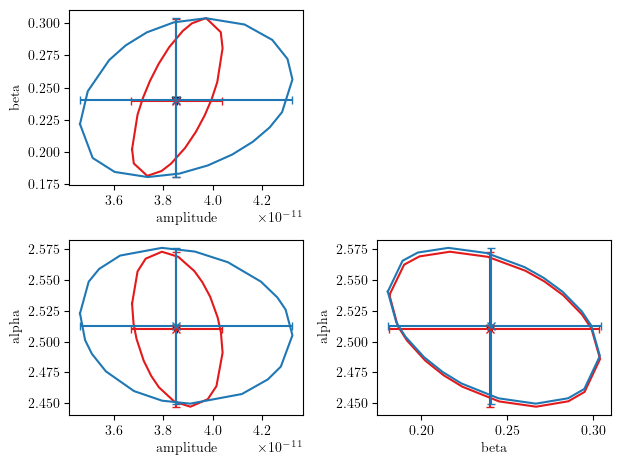

In [9]:
def contour_plot(axs):
    alpha = 0.2
    
    #fig,axs = plt.subplots(2,2)
    #axs = axs.flatten()
    #axs = [axs[1][0], axs[0][0], axs[1][1], axs[0][1]]
    for i,p in enumerate(parameter_names):
        a = results[i][f'{dataset_asimov.models[0].name}.spectral.{p[0]}']    
        b = results[i][f'{dataset_asimov.models[0].name}.spectral.{p[1]}']
        axs[i].plot(a, b, color = awo[0])
        for j, d in enumerate([dataset_asimov, dataset_asimov_N]):
            xen = d.models[0].parameters[p[0]].error_n
            xep = d.models[0].parameters[p[0]].error_p
            yen = d.models[0].parameters[p[1]].error_n
            yep = d.models[0].parameters[p[1]].error_p
            x = d.models[0].parameters[p[0]].value
            y = d.models[0].parameters[p[1]].value
            axs[i].errorbar(x, y, xerr=np.array([[xen ,xep]]).T,
                            yerr=np.array([[yen ,yep]]).T, color = colors_[j], capsize = 3,
                fmt='x')
        a = results_N[i][f'{dataset_asimov.models[0].name}.spectral.{p[0]}']    
        b = results_N[i][f'{dataset_asimov.models[0].name}.spectral.{p[1]}']
        axs[i].plot(a, b, color = aw[0])
        axs[i].scatter (dataset_input.models[0].parameters[p[0]].value,
                         dataset_input.models[0].parameters[p[1]].value,
                        color = 'black',
                        marker = 'v',
                        label = "input"
                       )
        axs[i].set_xlabel(p[0])
        axs[i].set_ylabel(p[1]) 
       
    #axs[-1].axis('off')
    
    return axs

fig,axs = plt.subplots(2,2)
colors_ = [awo[0], aw[0]]
#axs = axs.flatten()
axs = [axs[1][0], axs[0][0], axs[1][1], axs[0][1]]

contour_plot(axs)
plt.tight_layout()
axs[-1].axis('off')
plt.savefig(f"../{c['folder']}/plots/7_contours.pdf")

### RNDs

In [10]:
infos = np.loadtxt(f"../{c['folder']}/data/1_P_draw_info.txt")
N_max = 100
shift_rnds = infos[:N_max, 0]
index_rnds = infos[:N_max, 1]
res_rnds = infos[:N_max, 2]
bias_rnds = infos[:N_max, 3]


pars_N = np.loadtxt(f"../{c['folder']}/data/1_N_P_draw_par.txt")
pars = np.loadtxt(f"../{c['folder']}/data/1_P_draw_par.txt")

lives = pars_N[:N_max, -1:]

results_rnds, results_rnds_N = [], []
path = f'../{folder}'
for i in range(len(shift_rnds)):
    s = shift_rnds[i]
    t = index_rnds[i]
    r = res_rnds[i]
    b = bias_rnds[i]
    rnds = f"{s:.6}_{t:.6}_{r:.6}_{b:.6}"
    l = lives[i][0]
    
parameters =  ['amplitude', 'alpha', 'beta', 'norm', 'tilt']
par_values_N = dict()
par_values = dict()
for p in parameters:
    par_values_N[p] = []
    par_values[p] = []

for j in range(len(pars_N)):
    for i in range(len(parameters)):
        p = pars_N[j][i*2: i*2+1]
        par_values_N[parameters[i]].append(p)
        p = pars[j][i*2: i*2+1]
        par_values[parameters[i]].append(p)


In [11]:
from scipy.interpolate import interp1d
def interpolate(one, two):
    
    points = np.column_stack((one, two))  # a (nbre_points x nbre_dim) array
    

    # Linear length along the line:
    distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1 )) )
    distance = np.insert(distance, 0, 0)/distance[-1]

    # Interpolation for different methods: #quadratic
    interpolations_methods = ['linear']
    alpha = np.linspace(0, 1, 75)

    interpolated_points = {}
    for method in interpolations_methods:
        interpolator =  interp1d(distance, points, kind=method, axis=0)
        interpolated_points[method] = interpolator(alpha)
        
    for method_name, curve in interpolated_points.items():
        c_int = {'x':curve.T[0], 'y': curve.T[1]}
    return np.array(c_int['x']), np.array(c_int['y'])



In [12]:
names = {'amplitude':"Amplitude [1/TeVcm2s]", 
        'alpha':"$\\alpha$",
        'beta':"$\\beta$"}

In [13]:
alpha = 0.2
    
def histogram(axs, parameters_hist):
    vs = []
    for i,p_ in enumerate(parameters_hist):
        
        p = dataset_asimov.models[0].parameters[p_]
        r = p.value-sig * p.error , p.value+sig * p.error
        bins  = np.linspace(r[0], r[1], 30) 
        
        if i ==2:
            orientation = 'horizontal'
            axs[i].set_ylim(p.value-sig * p.error , p.value+sig * p.error , )
                
        else:
            orientation = 'vertical'
            axs[i].set_xlim(p.value-sig * p.error , p.value+sig * p.error , )
            
        n, bins, pat = axs[i].hist(np.array(par_values[p_]).ravel(), bins = bins, orientation= orientation,
                                  color = ewo[1],
                                   label = "W/o fitting sys.")
        axs[i].hist(np.array(par_values_N[p_]).ravel(), bins = bins, orientation= orientation,
                     histtype='step', color= ew[0], linewidth = 2, alpha = 0.8,
                    label = "With fitting sys."
                   )
        if i ==2:
            axs[i].hlines(p.value, 0, ax_b.get_xlim()[1], color = 'black', alpha = 0.8)

        else:
            axs[i].vlines(p.value, 0, ax_a.get_ylim()[1], color = 'black', alpha = 0.8)

  
    ax_a.xaxis.set_label_position("top")
    ax_a.set_xlabel(names[parameters_hist[0]])

    ax_b.yaxis.set_label_position("right")
    ax_b.yaxis.tick_right()
    ax_b.set_ylabel("$\\alpha$",)
    ax_b.tick_params(left = 0, labelleft  = 0,  right = 1,  labelright=1, bottom=1, labelbottom=False)

    ax_c.tick_params(left = 0, labelleft  = 0,  top = 1,  labeltop=1, bottom=1, labelbottom=False)
    ax_c.xaxis.set_label_position("top")
    ax_c.set_xlabel("$\\beta$")

    axs_2.set_xlabel("")
    axs_2.tick_params(top = 0, labeltop  = 0, )
    axs_3.yaxis.set_label_position("right")
    axs_3.yaxis.tick_right()

    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.1, 
                        hspace=0.1)
    #axs[i].scatter(par_values[p[0]], par_values[p[1]],marker =  'x', alpha = alpha, color = ewo[0])
    #axs[i].scatter(par_values_N[p[0]], par_values_N[p[1]],marker =  'o', alpha = alpha, color = ew[0])
    return axs

def plot_scatter(axs):
    for i,p in enumerate(parameter_names):
    
        axs[i].scatter(par_values[p[0]], par_values[p[1]],marker =  'x', alpha = alpha, color = ewo[0])
        axs[i].scatter(par_values_N[p[0]], par_values_N[p[1]],marker =  'o', alpha = alpha, color = ew[0])


    for i in range(len(results_rnds)):
        r = results_rnds[i]
        r_N = results_rnds_N[i]

        cs = plot_results(r, axs, color = ewo[0])
        cs_N = plot_results(r_N, axs, color = ew[0])
        for i, c_ in enumerate( cases):
            wihtin[c_].append(cs[i])
            wihtin_N[c_].append(cs_N[i])

    for i,p_ in enumerate(parameter_names):
        p = dataset_asimov.models[0].parameters[p_[1]]
        axs[i].set_ylim(p.value-sig * p.error , p.value+sig * p.error , )
        axs[i].set_ylabel(names[p.name])
        p = dataset_asimov.models[0].parameters[p_[0]]
        axs[i].set_xlim(p.value-sig * p.error , p.value+sig * p.error , )
        axs[i].set_xlabel(names[p.name])
    plt.tight_layout()
    return axs


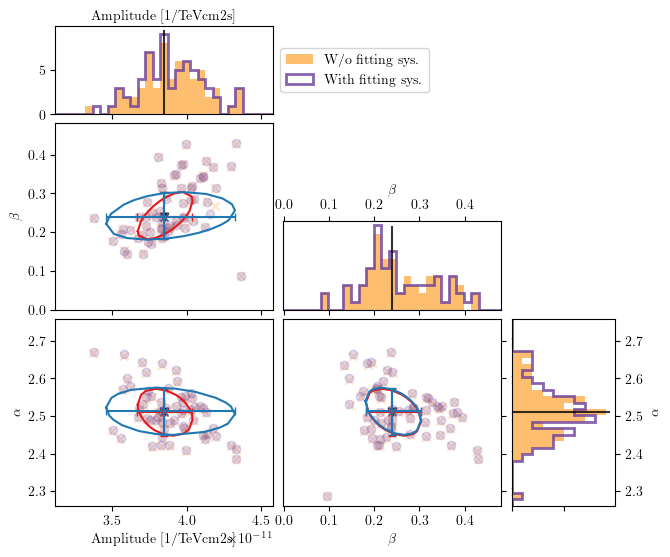

In [14]:
y2 = 2
sig = 4

fig3 = plt.figure( figsize = (7,6))
gs = fig3.add_gridspec(5, 5)
ax_a = fig3.add_subplot(gs[0, 0:2])
axs_2 = fig3.add_subplot(gs[1:3, 0:2])
axs_1 = fig3.add_subplot(gs[3:5, 0:2])

ax_c = fig3.add_subplot(gs[2:3,  2:4])
axs_3 = fig3.add_subplot(gs[3:5,  2:4])
ax_b = fig3.add_subplot(gs[3:5,  4:5])

axs = contour_plot([axs_1, axs_2, axs_3])
axs = plot_scatter([axs_1, axs_2, axs_3])
parameters_hist = ["amplitude", "beta", "alpha"]

axs = histogram([ax_a, ax_c, ax_b], parameters_hist)

ax_a.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#axs_1.legend()
plt.show()
fig3.savefig(f"../{c['folder']}/plots/7_summary.pdf")

In [15]:
par_values

{'amplitude': [array([3.79375575e-11]),
  array([3.73040015e-11]),
  array([3.56634404e-11]),
  array([6.02243327e-11]),
  array([1.65483889e-11]),
  array([4.12271456e-11]),
  array([3.37163743e-11]),
  array([3.83778236e-11]),
  array([4.85286362e-11]),
  array([4.32756696e-11]),
  array([4.36447513e-11]),
  array([4.13677041e-11]),
  array([3.98903144e-11]),
  array([3.08425491e-11]),
  array([4.64788732e-11]),
  array([4.0934688e-11]),
  array([5.69795186e-15]),
  array([4.19286791e-11]),
  array([4.08860282e-11]),
  array([3.83154831e-11]),
  array([3.7565777e-11]),
  array([3.83471634e-11]),
  array([4.04682797e-11]),
  array([4.02489705e-11]),
  array([3.50147076e-11]),
  array([3.62564736e-11]),
  array([3.85039733e-11]),
  array([3.80797991e-11]),
  array([3.55639568e-11]),
  array([3.82550465e-11]),
  array([3.81349428e-11]),
  array([3.76566348e-11]),
  array([4.12999282e-11]),
  array([4.11056816e-11]),
  array([3.70679449e-11]),
  array([3.73400118e-11]),
  array([3.835296

In [32]:
import matplotlib.path as mpltPath
withins = []
for r in [results, results_N]:
    w = []
    for i,p in enumerate(parameter_names):
        a = r[i][f'{dataset_asimov.models[0].name}.spectral.{p[0]}']    
        b = r[i][f'{dataset_asimov.models[0].name}.spectral.{p[1]}']
        path = mpltPath.Path(np.column_stack((a, b)))
        masks = []
        for pars0, pars1 in zip(par_values[p[0]], par_values[p[1]]):
            mask = path.contains_points(points = ([(pars0[0], pars1[0])]))
            masks.append(mask[0])
        withins.append(np.count_nonzero(masks)/ len(masks))
print(withins)



[0.32857142857142857, 0.2857142857142857, 0.24285714285714285, 0.5142857142857142, 0.4857142857142857, 0.22857142857142856]
